# Pre-Processing

Here are a fraction of the packages you will want to use for text processing. 

In [34]:
import os
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import numpy as np
import pandas as pd

#Text & Number Manipulation
import re
import string
from string import punctuation
from num2words import num2words

#Plotting
import matplotlib
import matplotlib.pyplot as plt #for plotting

#Initiliaze Lemmatizer, Stopwords Handler, and Wordnet Map (For Later Use)
lemmatizer = WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

# Read and Verify Text

In [35]:
os.chdir("/mnt/c/users/lfult/desktop/")
total=pd.read_csv('annatotal.csv', dtype='str')
train=pd.read_csv('annatrain.csv', dtype='str')
test=pd.read_csv('annatest.csv', dtype='str')
train.head()

,Index,Type,Concatenate
0,1,HACK,STRATA Trust Company NA CA 7 17 2020 2 10 2020...
1,2,HACK,Gannett Company Inc. Gannett_Company_Inc.-6fc8...
2,10,HACK,Professional Personnel Services dba Luttrell S...
3,11,HACK,DJO LLC DJO_LLC-919d7617-69a2-4b25-8325-c2bd3c...
4,12,HACK,Talx Corporation NA MD 5 11 2017 4 17 2016 BSO...


# Build Feature Set

All missing were imputed with the text NA.  All fields were concatenated.


# Graph Frequencies

<AxesSubplot:xlabel='Word'>

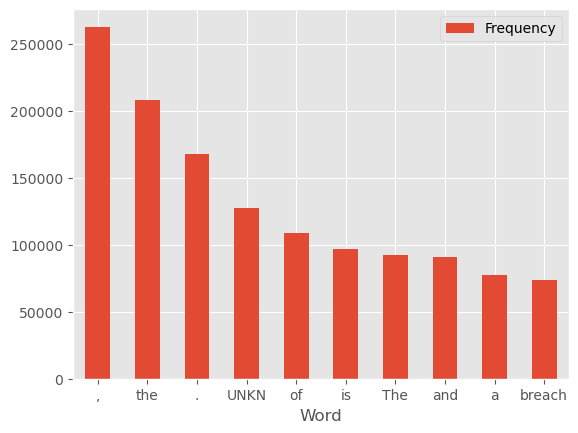

In [37]:
txt = train.Concatenate.str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
rslt = pd.DataFrame(word_dist.most_common(10), columns=['Word', 'Frequency']).set_index('Word')
matplotlib.style.use('ggplot')
rslt.plot.bar(rot=0)

# Text Processing, RNN Model

In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation, Embedding, Bidirectional, Dense, LSTM #pull in the dense, dropout, and flatten layers
from tensorflow.keras.preprocessing.text import Tokenizer #RNN
import tensorflow.keras #keras
from tensorflow.keras import Sequential,Input,Model #pull in the sequential, input layers and a model

oov_token = '<UNK>'   #out of vocabulary replacement
pad_type = 'post'     #padding type
trunc_type = 'post'   #truncation type
num_words = 50000  


tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
mybatch=8  #set batch size, learns better small for this data
embedding_size=128 #set out size for embedding
num_epochs=9 #set the number of epochs..
tf.random.set_seed(1234) #set random number seed for tensorflow, python, etc.

tokenizer.fit_on_texts(total.Concatenate.astype('str'))
train_sequences1 = tokenizer.texts_to_sequences(train.Concatenate.astype('str')) 
maxlen = max([len(x) for x in train_sequences1])
train_X = pad_sequences(train_sequences1, padding=pad_type, truncating=trunc_type, maxlen=maxlen)





# Apply to Test Set

In [122]:
test_sequences1 = tokenizer.texts_to_sequences(test.Concatenate.astype('str'))
test_X = pad_sequences(test_sequences1, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [50]:
print(train_X.shape,test_X.shape, train_y.shape)

(20043, 830) (3, 830) (20043, 9)


# Input Shapes

In [51]:
input_1 = Input(shape=(train_X.shape[1]))

# RNN

In [52]:
input_1 = Input(shape=train_X.shape[1])
v=Embedding(len(tokenizer.word_index) + 1, embedding_size)(input_1)
v=Bidirectional(LSTM(embedding_size, return_sequences=True, dropout=.5))(v)
v=Bidirectional(LSTM(embedding_size, return_sequences=False, dropout=.2))(v)
output=Dense(16,activation='relu')(v)
output=Dropout(.1)(output)
output=Dense(7, activation='softmax')(output)
model=Model(inputs=input_1, outputs=output)

# Model

In [53]:
model=Model(inputs=input_1, outputs=output)

with tf.device('/GPU:0'):    
    model = model
    SGD= tensorflow.keras.optimizers.SGD(learning_rate=0.0001, nesterov=True)
    adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0001)  #No rules in battle...but if there were, always carry a reserve.
    model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, 
              optimizer=adam, metrics=['categorical_accuracy'])
    model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 830)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 830, 128)          16490240  
                                                                 
 bidirectional_11 (Bidirect  (None, 830, 256)          263168    
 ional)                                                          
                                                                 
 bidirectional_12 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                                 
 dense_9 (Dense)             (None, 16)                4112      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0   

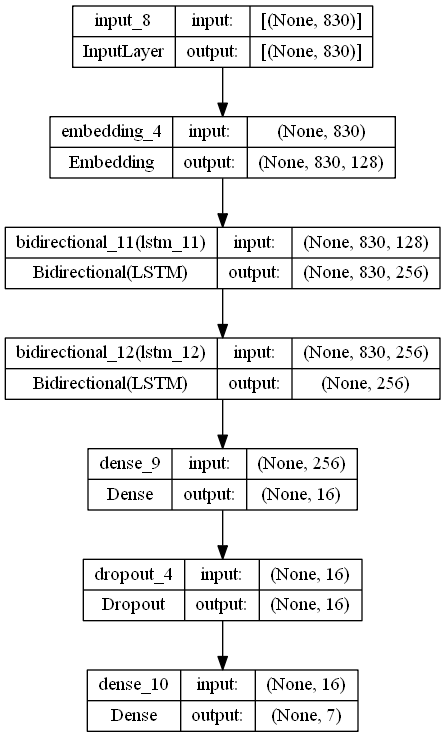

In [54]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True, expand_nested=False)

In [58]:
train_y=pd.get_dummies(train, columns=['Type'], dtype='int')
train_y=train_y.iloc[:,2:9].values
train_y

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

# Compile

In [117]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint 
tf.random.set_seed(1234)
tf.config.run_functions_eagerly(True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='categorical_accuracy', verbose=2,
    save_best_only=True, mode='auto')
history=model.fit(x=train_X,y=train_y,batch_size=mybatch,verbose=1,epochs=1, validation_split=.3, callbacks=[checkpoint]) 

/home/python8r/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1754/1754 [==============================] - ETA: 0s - loss: 0.1039 - categorical_accuracy: 0.9671
Epoch 1: categorical_accuracy improved from -inf to 0.96714, saving model to best_model.keras
1754/1754 [==============================] - 496s 283ms/step - loss: 0.1039 - categorical_accuracy: 0.9671 - val_loss: 0.1651 - val_categorical_accuracy: 0.9639


# Predict

In [123]:
predict=model.predict(test_X)

/home/python8r/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


473/473 [==============================] - 35s 75ms/step


In [125]:
from sklearn.metrics import confusion_matrix
preddf=pd.DataFrame(predict)
preddf.columns=['CARD', 'DISC', 'HACK', 'INSD', 'PHYS','PORT', 'STAT']
preddf['Index']=test['Index']
preddf
preddf.to_csv('Probabilities.csv',index=False)
